In [2]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

DPI = 600
GRANULARITY = 200000

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

containingJoinSplit = blocks.loc[(blocks['numberJoinSplit'] != 0)]

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])
blocks["SIZE"] = blocks["SIZE"] / 1024 # Convert to KB

Blocks 00000000026713f4ef22ffc0096547fe88ccfe3987605e4a73c0abc617f1e926 till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


In [3]:
containingJoinSplit.sort_values(by=['numberJoinSplit']).head()
containingJoinSplit.count()

BLOCK                    11337
BLOCK_NS_SSD             11337
BLOCK_NS_HDD             11337
SIZE                     11337
VERSION                  11337
numberTX                 11337
numberVin                11337
numberVout               11337
numberJoinSplit          11337
numbervShieldedSpend     11337
numbervShieldedOutput    11337
dtype: int64

<Figure size 432x288 with 0 Axes>

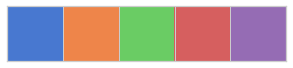

In [118]:
# Prepare plots
color = "muted"
sns.set(style="whitegrid", palette=color, color_codes=True)
sns.despine(left=True)
#plt.rcParams['figure.figsize'] = [16/2.54, 12/2.54]
color = sns.color_palette(color, 5)
sns.palplot(sns.color_palette(color, 5))
color_primary = color[0]
color_kb = color[2]
color_r2 = color[3]
color_kv = color[1]
color_gv = color[4]

In [5]:
blocks.loc[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK']), 'Blocks containing ...'] = 'Only transparent TX' 
blocks.loc[~blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK']), 'Blocks containing ...'] = '$> 1$ shielded TX'  
blocks.loc[blocks['BLOCK'].isin(containingJoinSplit['BLOCK']), 'Blocks containing ...'] = '$> 1$ JoinSplit TX'

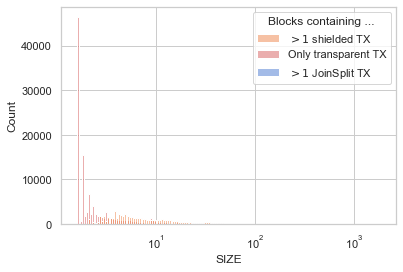

In [6]:
grid = sns.histplot(x="SIZE", data=blocks, hue='Blocks containing ...', log_scale=True, palette=[color_kv, color_r2, color_primary])

In [7]:
# Include block height
blocks_h = blocks.copy(deep=True)
tmp = blocks_info.copy(deep=True)
tmp = tmp.reset_index()
tmp = tmp.rename(columns = {'index':'height'})
blocks_h = blocks_h.merge(tmp, how='inner', left_on="BLOCK", right_on="BLOCK")
blocks_h = blocks_h.sort_values(by=['height'])
blocks_h['height'] = blocks_h['height'] / 1000

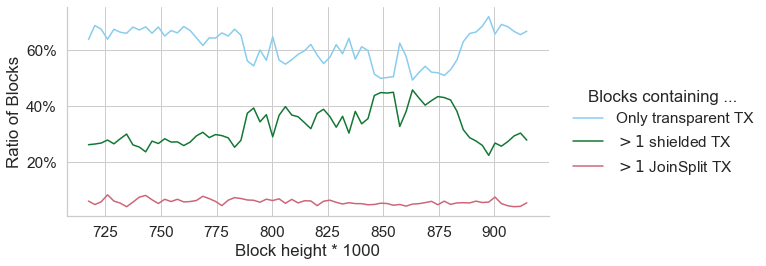

In [125]:
colors = ["#88CCEE", "#117733", "#CC6677", "#882255", "#AA4499"]
sns.set(style="whitegrid", color_codes=True, font_scale=1.4)

sns.set_palette(sns.color_palette(colors))

def move_legend(ax, new_loc, _ncol, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, ncol=_ncol, loc=new_loc, bbox_to_anchor=(0.5, -0.4), title=title, **kws)

BINS = 70
grid = sns.displot(bins=BINS, kind="hist", x="height", height=3, aspect=2, data=blocks_h, hue='Blocks containing ...', element="poly", fill=False, multiple='layer',weights=np.ones(len(blocks_h)) / (len(blocks_h) / BINS))
grid.set(xlabel='Block height * 1000', ylabel='Ratio of Blocks')
for ax in grid.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
grid.savefig("top.pdf", bbox_inches='tight', dpi=DPI)